# Dynamic characterization
This notebook is meant to explain the options for dynamic characterization in `bw_timex`.
In this example, there is a very simple database containing only one node with a pulse emission of CH4, occuring at a 10 year delay.

Further down, there is an example with multiple greenhouse gases.


In [17]:
import bw2data as bd
import numpy as np
from bw_temporalis import TemporalDistribution

project_name = "timex_example_dynamic_characterization"
if project_name in bd.projects:
    bd.projects.delete_project(project_name) # making sure to start from scratch
    bd.projects.purge_deleted_directories()

bd.projects.set_current(project_name)

bd.Database("temporalis-bio").write(
    {
        ("temporalis-bio", "CH4"): {  # only biosphere flow is CH4
            "type": "emission",
            "name": "methane",
            "temporalis code": "ch4",
        },
    }
)

bd.Database("test").write(  # dummy system containing 1 activity
    {
        ("test", "A"): {
            "name": "A",
            "location": "somewhere",
            "reference product": "a",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("test", "A"),
                },
                {
                    "amount": 1,
                    "type": "biosphere",
                    "input": ("temporalis-bio", "CH4"),
                    "temporal_distribution": TemporalDistribution(
                        date=np.array([10], dtype="timedelta64[Y]"),
                        amount=np.array([1]),
                    ),  # emission of CH4 10 years after execution of process A
                },
            ],
        },
    }
)

bd.Method(("GWP", "example")).write(
    [
        (("temporalis-bio", "CH4"), 29.8),  # GWP100 from IPCC AR6
    ]
)

100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 20763.88it/s]

Vacuuming database 


We select the demand and the method and calculate a LCA with `bw_timex`


In [18]:
demand = {("test", "A"): 1}
gwp = ("GWP", "example")

In [19]:
from bw_timex import TimexLCA

tlca = TimexLCA(demand, gwp)

/Users/timodiepers/Documents/Coding/timex/bw_timex/timex_lca.py:101: UserWarning: No database_date_dict provided. Treating the databases containing the functional unit as dynamic. No remapping to time explicit databases will be done.
  warnings.warn(


In [20]:
tlca.build_timeline()

Starting graph traversal
Calculation count: 0


/Users/timodiepers/Documents/Coding/timex/bw_timex/timex_lca.py:183: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(
/Users/timodiepers/Documents/Coding/timex/bw_timex/timeline_builder.py:353: Warning: No time-explicit databases are provided. Mapping to time-explicit databases is not possible.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2024-01-01,A,2024-01-01,-1,1.0,None


In [21]:
tlca.lci()

In [22]:
tlca.static_lcia()
tlca.static_score

29.799999237060547

## Dynamic characterization

While users can provide their own dynamic LCIA methods, `bw_timex` works with the dynamic characterization functions from the package `dynamic_characterization`, which are based on IPCC AR6.

These dynamic characterization functions can be evaluated for the two metrics:
- radiative forcing [W/m2]
- Global warming potential (GWP) [kg CO2eq],

For these dynamic LCIA metrics, users can select the length of the considered time horizon (`time_horizon`) and whether it is a fixed time horizon (`fixed_time_horizon`).

Conventional metrics usually consider a time horizon of 100 years, but this has been more of a value choice.
Fixed time horizon means that the time horizon for all emissions (no matter when they occur) starts counting at the time of the functional unit, resulting in shorter time horizons for emissions occuring later. This approach has been proposed by [Levasseur et al. 2010](https://pubs.acs.org/doi/10.1021/es9030003) to harmonize the time frame chosen for the analysis and the time period covered by the LCA results.
If the time horizon is not fixed (this is what conventional impact assessment factors assume), it starts counting from the timing of the emission.


First, import the dynamic characterization function of CH4 and have a look at it:


In [23]:
from dynamic_characterization.timex.radiative_forcing import characterize_ch4

Then, we can create the characterization_function_dict where we map the function to the corresponding flow via its ID:

In [24]:
characterization_function_dict_ch4 = {
    bd.get_node(code="CH4").id: characterize_ch4,
}

In [25]:
tlca.dynamic_lcia(
    metric="radiative_forcing",
    fixed_time_horizon=True,
    characterization_function_dict=characterization_function_dict_ch4,
)

,date,amount,flow,activity
0,2034-12-31 16:01:12,1.922234e-13,1,3
1,2035-12-31 21:50:24,1.766044e-13,1,3
2,2036-12-31 03:39:36,1.622546e-13,1,3
3,2037-12-31 09:28:48,1.490707e-13,1,3
4,2038-12-31 15:18:00,1.369581e-13,1,3
...,...,...,...,...
85,2120-01-01 06:43:12,1.430256e-16,1,3
86,2120-12-31 12:32:24,1.314042e-16,1,3
87,2121-12-31 18:21:36,1.207270e-16,1,3
88,2123-01-01 00:10:48,1.109175e-16,1,3


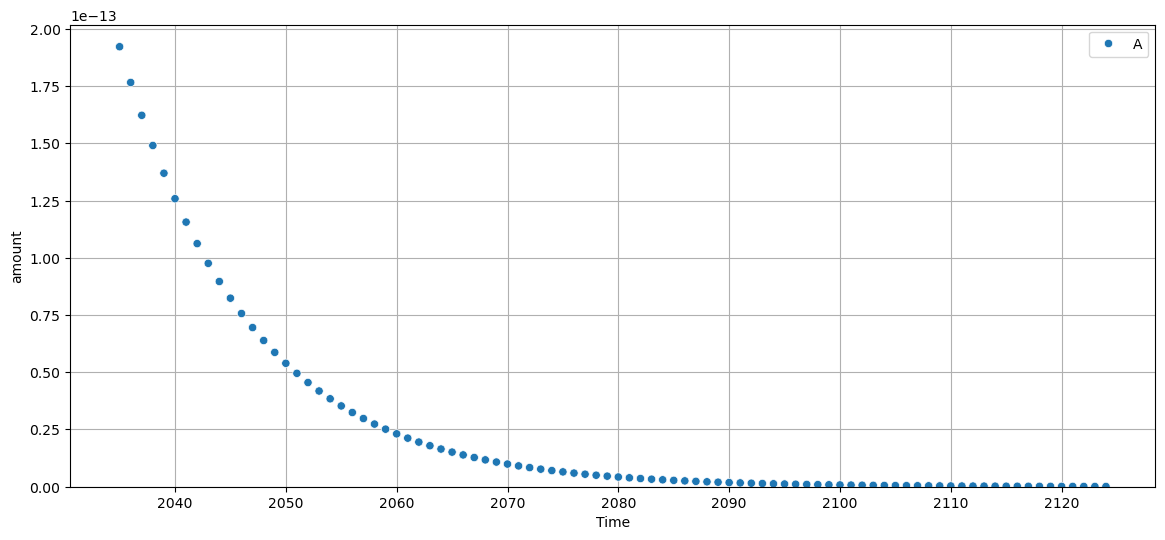

In [26]:
tlca.plot_dynamic_characterized_inventory()

CH4 has a half-life time of 8.6 years, so the decay curve is quite steep and it doesn't cause much atmospheric warming in later years.


In [27]:
print(
    f"characterized dynamic score: {tlca.dynamic_score}"
)

characterized dynamic score: 2.364552528630073e-12


If we evaluate radiative forcing over a shorter time horizon, the score gets smaller. This is equivalent to taking a shorter integral of the radiative forcing curve above.


In [28]:
tlca.dynamic_lcia(
    metric="radiative_forcing",
    fixed_time_horizon=False,
    time_horizon=20,
    characterization_function_dict=characterization_function_dict_ch4,
)

print(
    f"characterized dynamic score: {tlca.dynamic_score}"
)

characterized dynamic score: 1.892909832719887e-12


With `fixed_time_horizon = True`, we evaluate all emissions from time of the functional unit, regardless when they actually occur. As our CH4 emission occurs 10 year later than the functional unit, this means that it is only assessed for 90 years (100 years time horizon - 10 years of delay in emission). As CH4 is barely causing warming between year 90 to 100, this doesn't change the overall score too much, but can cause larger differences for more long-lived GHGs.


characterized dynamic score: 2.364552528630073e-12


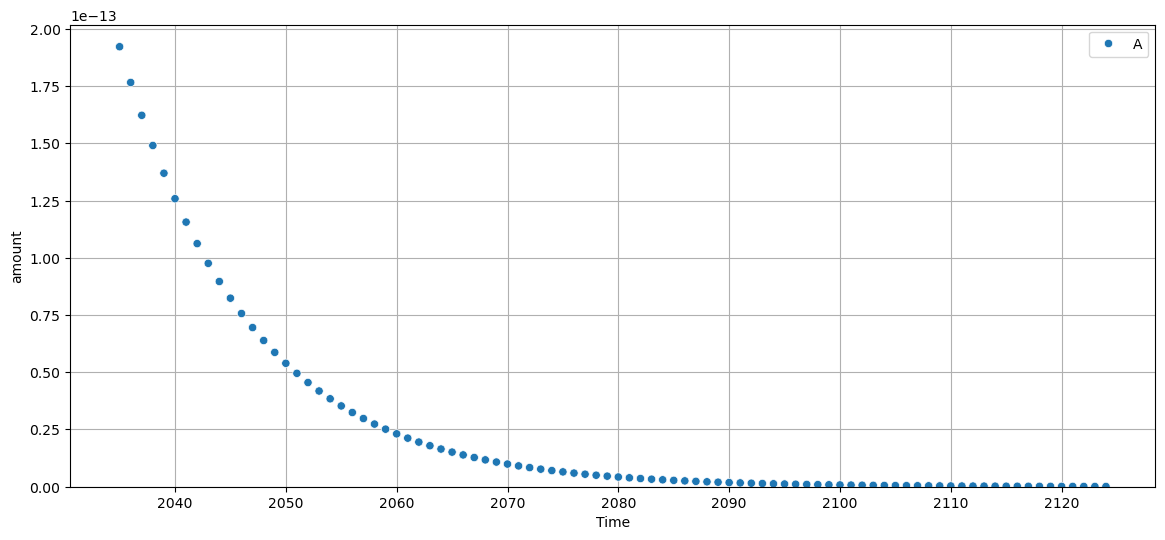

In [29]:
tlca.dynamic_lcia(
    metric="radiative_forcing",
    fixed_time_horizon=True,
    time_horizon=100,
    characterization_function_dict=characterization_function_dict_ch4,
)

print(
    f"characterized dynamic score: {tlca.dynamic_score}"
)

tlca.plot_dynamic_characterized_inventory()

Note that the tail of the curve stops in 21**2**4 (100 years after the functional unit), in 21**3**4 (100 years after the emission) in the figure a few cells above.


### Global warming potential (GWP)


GWP describes the warming of a GHG in comparison to that of the reference gas CO2. As such, it divides the integral of radiative forcing of a GHG over a certain time horizon by the integral of radiative forcing of the reference gas CO2 over the same time horizon:

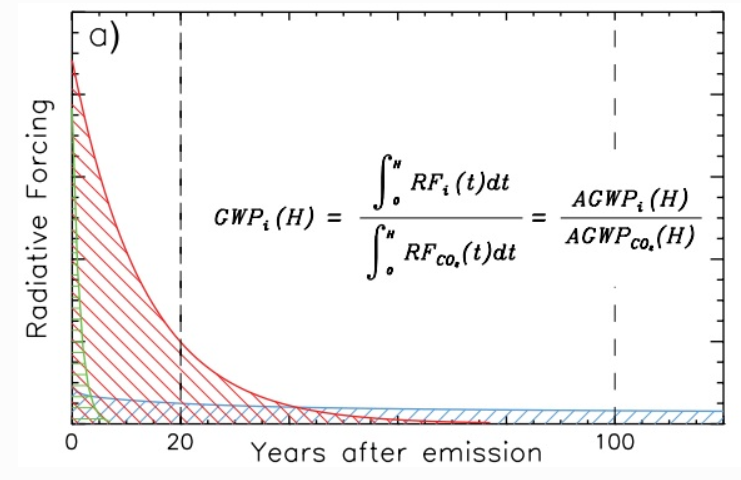

[KTH, 2014](https://www.energy.kth.se/applied-thermodynamics/key-research-areas/heating-systems/low-gwp-news/nagot-om-hur-gwp-varden-bestams-1.474589)


GWP can be calculated in `bw_timex` with the same options as radiative forcing:

- time horizon can vary (default 100 years)
- fixed or flexible time horizon


Let's evaluate GWP20:


In [30]:
tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=20,
    characterization_function_dict=characterization_function_dict_ch4,
)

print(
    f"characterized dynamic score: {tlca.dynamic_score}"
)

characterized dynamic score: 81.38137397247695


/Users/timodiepers/Documents/Coding/dynamic_characterization/dynamic_characterization/dynamic_characterization.py:258: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


With `fixed_time_horizon = True` and `time_horizon = 20` years, the difference in results is substantial, as the 10-years delayed CH4 emission is only counted for 10 years (20 year time horizon starting at the functional unit - 10 year emissiond delay).


In [31]:
tlca.dynamic_lcia(
    metric="GWP",
    fixed_time_horizon=True,
    time_horizon=20,
    characterization_function_dict=characterization_function_dict_ch4,
)

print(
    f"characterized dynamic score: {tlca.dynamic_score}"
)

characterized dynamic score: 58.12589062375878


/Users/timodiepers/Documents/Coding/dynamic_characterization/dynamic_characterization/dynamic_characterization.py:258: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


## Example with more GHGs

Lastly, let's look at a system with multiple GHGs spread over time.


In [32]:
def write_database_multi_emission():

    project_name = "__test_database1__"
    if project_name in bd.projects:
        bd.projects.delete_project(project_name)
        bd.projects.purge_deleted_directories()

    bd.projects.set_current(project_name)

    bd.Database("temporalis-bio").write(
        {
            ("temporalis-bio", "CH4"): {
                "type": "emission",
                "name": "methane",
                "temporalis code": "ch4",
            },
            ("temporalis-bio", "CO2"): {
                "type": "emission",
                "name": "carbon dioxide",
                "temporalis code": "co2",
            },
            ("temporalis-bio", "N2O"): {
                "type": "emission",
                "name": "nitrious oxide",
                "temporalis code": "n2o",
            },
        }
    )

    bd.Database(
        "test"
    ).write(  # dummy system containing 1 activity with multiple emissions
        {
            ("test", "A"): {
                "name": "A",
                "location": "somewhere",
                "reference product": "a",
                "exchanges": [
                    {
                        "amount": 1,
                        "type": "production",
                        "input": ("test", "A"),
                    },
                    {
                        "amount": 0.5,
                        "type": "biosphere",
                        "input": ("temporalis-bio", "CH4"),
                        "temporal_distribution": TemporalDistribution(
                            date=np.array([10, 15], dtype="timedelta64[Y]"),
                            amount=np.array([0.5, 0.5]),
                        ),  # emission of CH4 10 and 15 years after execution of process A
                    },
                    {
                        "amount": 20,
                        "type": "biosphere",
                        "input": ("temporalis-bio", "CO2"),
                        "temporal_distribution": TemporalDistribution(
                            date=np.array([-10, 5], dtype="timedelta64[Y]"),
                            amount=np.array([0.5, 0.5]),
                        ),  # emission of CO2 10 and 5 years before
                    },
                    {
                        "amount": 0.05,
                        "type": "biosphere",
                        "input": ("temporalis-bio", "N2O"),
                        "temporal_distribution": TemporalDistribution(
                            date=np.array([0], dtype="timedelta64[Y]"),
                            amount=np.array([1]),
                        ),  # emission of N2O at the same time
                    },
                ],
            },
        }
    )

    bd.Method(("GWP", "example")).write(
        [
            (("temporalis-bio", "CH4"), 29.8),  # GWP100 from IPCC AR6
            (("temporalis-bio", "N2O"), 273),
            (("temporalis-bio", "CO2"), 1),
        ]
    )

In [33]:
write_database_multi_emission()

100%|██████████| 3/3 [00:00<00:00, 28597.53it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 22671.91it/s]

Vacuuming database 


Import additional default dynamic characterization function for N2O and calculate time-explicit LCA.


In [34]:
from dynamic_characterization.timex.radiative_forcing import characterize_n2o, characterize_co2

demand = {("test", "A"): 1}
gwp = ("GWP", "example")

tlca = TimexLCA(demand, gwp)
tlca.build_timeline()
tlca.lci()
tlca.static_lcia()

Starting graph traversal
Calculation count: 0


/Users/timodiepers/Documents/Coding/timex/bw_timex/timex_lca.py:101: UserWarning: No database_date_dict provided. Treating the databases containing the functional unit as dynamic. No remapping to time explicit databases will be done.
  warnings.warn(
/Users/timodiepers/Documents/Coding/timex/bw_timex/timex_lca.py:183: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(
/Users/timodiepers/Documents/Coding/timex/bw_timex/timeline_builder.py:353: Warning: No time-explicit databases are provided. Mapping to time-explicit databases is not possible.
  warnings.warn(


match dynamic charcterization functions to biosphere flows:


In [35]:
characterization_function_dict = {
    bd.get_node(code="CH4").id: characterize_ch4,
    bd.get_node(code="CO2").id: characterize_co2,
    bd.get_node(code="N2O").id: characterize_n2o,
}

### Radiative forcing:


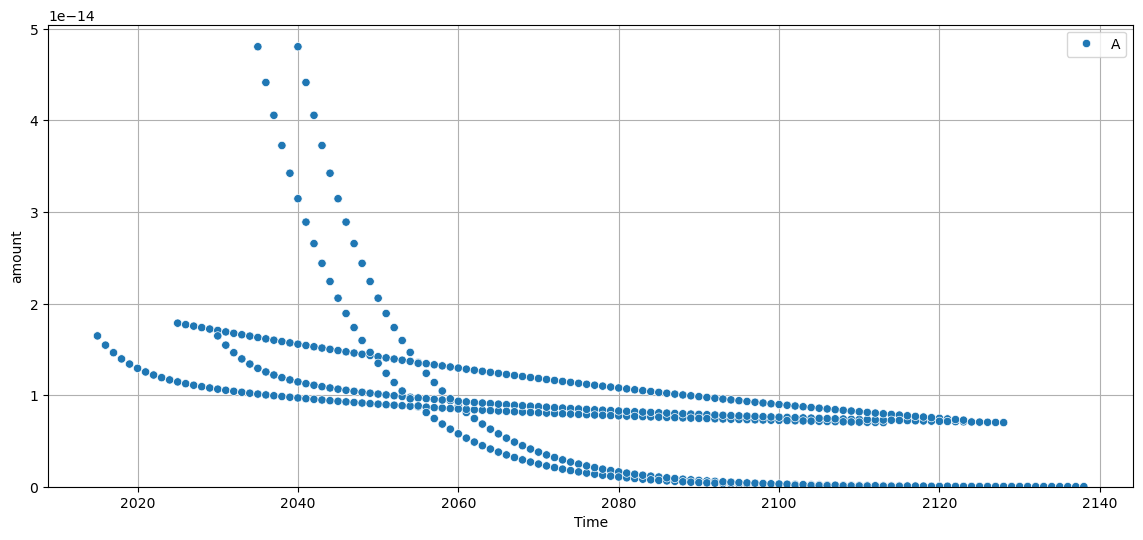

characterized dynamic score: 4.121262160040557e-12


In [36]:
tlca.dynamic_lcia(
    metric="radiative_forcing",
    time_horizon=100,
    characterization_function_dict=characterization_function_dict,
)
tlca.plot_dynamic_characterized_inventory()

print(
    f"characterized dynamic score: {tlca.dynamic_score}"
)

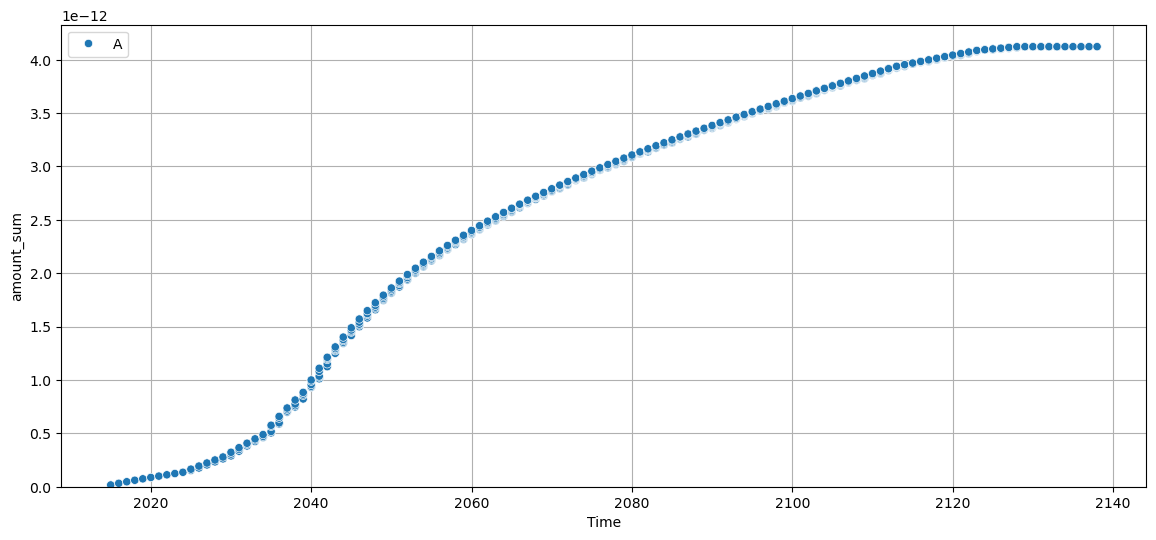

In [37]:
tlca.plot_dynamic_characterized_inventory(cumsum=True)

### Global warming potential:


/Users/timodiepers/Documents/Coding/dynamic_characterization/dynamic_characterization/dynamic_characterization.py:258: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


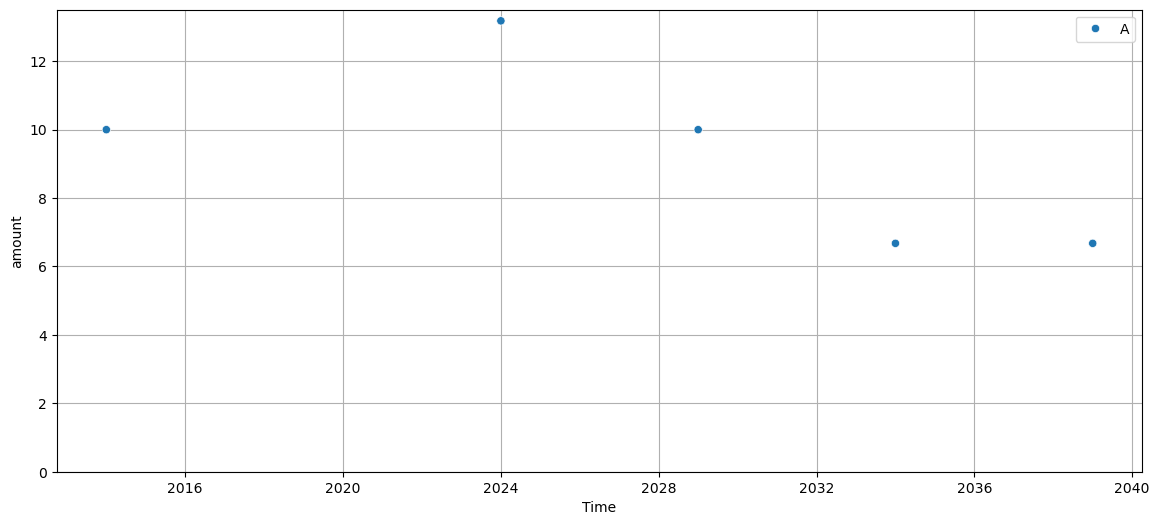

characterized dynamic score: 46.53439734089549


In [38]:
tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=100,
    characterization_function_dict=characterization_function_dict,
)
tlca.plot_dynamic_characterized_inventory()
print(
    f"characterized dynamic score: {tlca.dynamic_score}"
)

Ultimately, let's compare how changing the length of the time horizon affects the GWP results:


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

gwp_flexible_TH = {}
gwp_fixed_TH = {}

for time_horizon in range(20, 110, 10):  # 20 to 100 TH in steps of 10 years
    tlca.dynamic_lcia(
        metric="GWP",
        time_horizon=time_horizon,
        fixed_time_horizon=True,
        characterization_function_dict=characterization_function_dict,
    )
    gwp_fixed_TH[time_horizon] = tlca.dynamic_score

    tlca.dynamic_lcia(
        metric="GWP",
        time_horizon=time_horizon,
        fixed_time_horizon=False,
        characterization_function_dict=characterization_function_dict,
    )
    gwp_flexible_TH[time_horizon] = tlca.dynamic_score

# add values for 500 years:
tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=500,
    fixed_time_horizon=True,
    characterization_function_dict=characterization_function_dict,
)
gwp_fixed_TH[500] = tlca.dynamic_score

tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=500,
    fixed_time_horizon=False,
    characterization_function_dict=characterization_function_dict,
)
gwp_flexible_TH[500] = tlca.dynamic_score

df = pd.DataFrame(
    {
        "Time horizon": list(gwp_fixed_TH.keys()),
        "GWP (fixed time horizon)": list(gwp_fixed_TH.values()),
        "GWP (flexible time horizon)": list(gwp_flexible_TH.values()),
    }
)

/Users/timodiepers/Documents/Coding/dynamic_characterization/dynamic_characterization/dynamic_characterization.py:258: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(
/Users/timodiepers/Documents/Coding/dynamic_characterization/dynamic_characterization/dynamic_characterization.py:258: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(
/Users/timodiepers/Documents/Coding/dynamic_characterization/dynamic_characterization/dynamic_characterization.py:258: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(
/Users/timodiepers/Documents/Coding/dynamic_characterization/dynamic_characterization/dynamic_characterization.py:258: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(
/Users/timodiepers/Documents/Coding/dynamic_characterization/dynamic_characterization/dynamic_characterizati

In [40]:
df

,Time horizon,GWP (fixed time horizon),GWP (flexible time horizon)
0,20,60.238109,74.144077
1,30,63.544384,66.502783
2,40,60.862548,60.944071
3,50,57.576457,56.883182
4,60,54.678061,53.825761
5,70,52.268972,51.439676
6,80,50.271353,49.511978
7,90,48.591039,47.906378
8,100,47.151518,46.534397
9,500,30.084113,29.977030


One can see that a longer time horizon leads to smaller differences between fixed (time horizon starts at FU for all flows) and flexible time horizons (time horizon starts at each emissions seperately). An increase in time horizon also leads to lower overall scores, because the system contains multiple short-lived GHGs, such as CH4 and N2O, whose CO2-equivalence value decreases when assessing longer time horizons.
